## Quadrature integration

Quadrature methods, or numerical integration, is broad class of
algorithm for performing integration of any function $g$ that are
defined without requiring an analytical definition. In the scope of
`chaospy` we limit this scope to focus on methods that can be reduced to
the following approximation:

$$\int p(q) g(q) dx \approx \sum_{n=1}^N W_n g(Q_n)$$

Here $p(q)$ is an weight function, which is assumed to be an probability
density function, and $W_n$ and $Q_n$ are respectively quadrature
weights and abscissas used to define the approximation.

The simplest application of such an approximation is Monte Carlo
integration. In Monte Carlo you only need to select $W_n=1/N$ for all
$n$ and $Q_n$ to be independent identical distributed samples drawn from
the distribution of $p(q)$. For example:

In [1]:
import numpy
import chaospy

from problem_formulation import joint

joint

J(Normal(mu=1.5, sigma=0.2), Uniform(lower=0.1, upper=0.2))

In [2]:
nodes = joint.sample(500, seed=1234)
weights = numpy.repeat(1/500, 500)

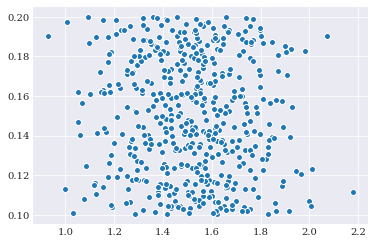

In [3]:
from matplotlib import pyplot

pyplot.scatter(*nodes)
pyplot.show()

Having the nodes and weights, we can now apply the quadrature integration.
for a simple example, this might look something like:

In [4]:
from problem_formulation import model_solver

evaluations = numpy.array([model_solver(node) for node in nodes.T])
estimate = numpy.sum(weights*evaluations.T, axis=-1)

How to apply quadrature rules to build model approximations is discussed in
more details in
[pseudo-spectral projection](../main_usage/pseudo_spectral_projection.ipynb).

### Gaussian quadrature

Most integration problems when dealing with polynomial chaos expansion
comes with a weight function $p(x)$ which happens to be the probability
density function. Gaussian quadrature creates weights and abscissas that
are tailored to be optimal with the inclusion of a weight function. It
is therefore not one method, but a collection of methods, each tailored
to different probability density functions.

In `chaospy` Gaussian quadrature is a functionality attached to each
probability distribution. This means that instead of explicitly supporting a
list of Gaussian quadrature rules, all feasible rules are supported through
the capability of the distribution implementation. For common distribution,
this means that the quadrature rules are calculated analytically, while
others are estimated using numerically stable methods.

Generating optimal Gaussian quadrature in `chaospy` by passing the flag
`rule="gaussian"` to the
[chaospy.generate_quadrature()](../../api/chaospy.generate_quadrature.rst)
function:

In [5]:
gauss_nodes, gauss_weights = chaospy.generate_quadrature(6, joint, rule="gaussian")

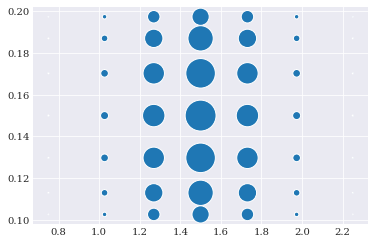

In [6]:
pyplot.scatter(*gauss_nodes, s=gauss_weights*1e4)
pyplot.show()

Since `joint` is bivariate consists of a normal and a uniform distribution,
the optimal quadrature here is a tensor product of Gauss-Hermite and
Gauss-Legendre quadrature.

### Weightless quadrature

Most quadrature rules optimized to a given weight function are part of the
Gaussian quadrature family. It does the embedding of the weight function
automatically as that is what it is designed for. This is quite convenient in
uncertainty quantification as weight functions in the form of probability
density functions is almost always assumed. For most other quadrature rules,
including a weight function is typically not canonical, however. So for
consistency and convenience, `chaospy` does a small trick and embeds the
influence of the weight into the quadrature weights:

$$\int p(q) g(q) dq \approx
  \sum_i W_i p(Q_i) g(Q_i) = \sum_i W^{*}_i g(Q_i)$$

Here we substitute $W^{*}=W_i p(Q_i)$. This ensures us that all quadrature
rules in `chaospy` behaves similarly as the Gaussian quadrature rules.

For our bivariate example, we can either choose a single rule for each
dimension, or individual rules. Since `joint` consists of both a normal and a
uniform, it makes sense to choose the latter. For example Genz-Keister is
know to work well with normal distributions and Clenshaw-Curtis should work
well with uniform distributions:

In [7]:
grid_nodes, grid_weights = chaospy.generate_quadrature(
    3, joint, rule=["genz_keister_24", "fejer_2"], growth=True)

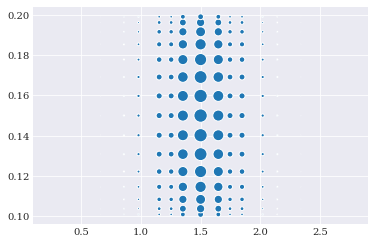

In [8]:
pyplot.scatter(*grid_nodes, s=grid_weights*6e3)
pyplot.show()

As a sidenote: Even though embedding the density function into the weights is
what is the most convenient think to do in uncertainty quantification, it
might not be what is needed always. So if one do not want the embedding, it
is possible to retrieve the classical unembedded scheme by replacing the
probability density function as the second argument of
[chaospy.generate_quadrature()](../../api/chaospy.generate_quadrature.rst)
with an interval of interest. For example:

In [9]:
interval = (-1, 1)
chaospy.generate_quadrature(4, interval, rule="clenshaw_curtis")

(array([[-1.        , -0.70710678,  0.        ,  0.70710678,  1.        ]]),
 array([0.06666667, 0.53333333, 0.8       , 0.53333333, 0.06666667]))

Also note that for quadrature rules that do require a weighting function,
passing an interval instead of an distribution will cause an error:

In [10]:
from pytest import raises

with raises(AssertionError):
    chaospy.generate_quadrature(4, interval, rule="gaussian")

### Smolyak sparse-grid

As the number of dimensions increases, the number of nodes and weights
quickly grows out of hands, making it unfeasible to use quadrature
integration. This is known as the curse of dimensionality, and except for
Monte Carlo integration, there is really no way to completely guard against
this problem. However there are a few ways to partially mitigate the problem,
like Smolyak sparse-grid. Smolyak sparse-grid uses a rule over a combination
of different quadrature orders and tailor it together into a new scheme. If
the quadrature nodes are more or less nested between the different quadrature
orders, as in the same nodes get reused a lot, then the Smolyak method can
drastically reduce the quadrature nodes needed.

To use Smolyak sparse-grid in `chaospy`, just pass the flag
`sparse=True` to the
[chaospy.generate_quadrature()](../../api/chaospy.generate_quadrature.rst)
function. For example:

In [11]:
sparse_nodes, sparse_weights = chaospy.generate_quadrature(
    3, joint, rule=["genz_keister_24", "clenshaw_curtis"], sparse=True)

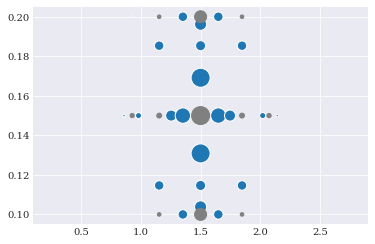

In [12]:
idx = sparse_weights > 0
pyplot.scatter(*sparse_nodes[:, idx], s=sparse_weights[idx]*2e3)
pyplot.scatter(*sparse_nodes[:, ~idx], s=-sparse_weights[~idx]*2e3, color="grey")
pyplot.show()

Note that in sparse-grid, the weights are often a mixture of positive and
negative values, as illustrated here with the two different colors.

Note here that the flag `growth=True` was used. This is because a few
quadrature rules that are nested only at particular orders. Passing the
`growth=True` flag implies that increasing at the order which is nested. This
affects the four quadrature rules: Clenshaw-Curtis, Fejér, Newton-Cotes and
grid.